# Notebook for model benchmark proof of concept
This notebook is linked as supplementary material for 
```
@misc{Lautrup2024,
    author          = {Lautrup, Anton D and Hyrup, Tobias and Zimek, Arthur and Schneider-Kamp, Peter}, 
    title           = {Systematic review of generative modelling tools and utility metrics for fully synthetic tabular data},
    year            = {2024},
}
```
which is currently under review for publication in ACM Computing Surveys. The notebook reproduces the experimental results obtained in the paper.

In the paper we survey the current scene of generative models for tabular data and utility metrics for evaluating the quality of synthetic data. We found that Generative Adversarial Networks (GANs), Bayesian Network (BN), and sequential Classification and Regression Tree (CART) models were the most documented and generally sucessfull models for generating synthetic data. To answer the question of how generative models can be compared in an objective and universal manner, we propose the following example of a model benchmark, implemented using our open-source Python library [SynthEval](https://github.com/schneiderkamplab/syntheval) ([Lautrup et al.](https://arxiv.org/abs/2404.15821)). 

In this example we pick one representative implementation of each model type: CTGAN ([Xu et al.](http://arxiv.org/abs/1907.00503)), DataSynthesizer ([Ping et al.](https://doi.org/10.1145/3085504.3091117)), and the synthpop CART ([Nowok et al.](https://doi.org/10.18637/jss.v074.i11)) model. The models are evaluated in their ability to generate useful and private synthetic data based on a wide range of benchmark datasets of different sizes. For each benchmark dataset the evaluation is based on a range of utility and privacy metrics, which together are used to clalulate a ranking index. When all the results are combined we can get an indication of which implementation are the most useful and private for generating synthetic data, and if there is any difference w.r.t. the size of the datasets.

## Generating the synthetic data
In this section we describe the process for generating the synthetic data. The actual code used can be found in the connected (utility-review-generate-data.ipynb)[notebook] or in the `generate_datasets.py` script (which assists executing the code on a more powerfull machine). The code will generate the same datasets as the ones supplied alongside this notebook, so recreating the synthetic datasets are not required for working thorugh this example.

We use the [Synthcity](https://github.com/vanderschaarlab/synthcity) implementation of CTGAN, and the official implementations of [DataSynthesizer](https://github.com/DataResponsibly/DataSynthesizer) and [synthpop](https://synthpop.org.uk/)  

For each dataset, we generate 3 synthetic datasets using each of the models, the best out of these three is saved (with respect to the SynthEval `fast_eval` metric overall rank). The time to fit the model and generate the data is also recorded and the mean time is saved in the `elapsed_times.csv`. The models are trained on 80% of the data and remaining 20% is saved to be used for some of the evaluation metrics. 


## Importing and evaluating datasets using SynthEval
Below we iteratively load the training and test data of every benchmark dataset, alongside the synthetic versions and send them all to the benchmark module of SynthEval. This generate a dataframe of the metric results and corresponding rank-derived scores. The results are formatted into a larger dataframe and saved to csv file for later analysis.

A parallelised version of this code can be found in the `evaluate_datasets.py` script. The code will generate the same results as the ones supplied alongside this notebook.

In [1]:
### File stuff
paths_and_targets = {
    'data/small_few_atts/diabetes': 'Outcome',
    'data/small_few_atts/penguins': 'species',
    'data/small_few_atts/titanic': 'Survived',
    'data/small_some_atts/cervical_cancer': 'Biopsy',
    'data/small_some_atts/derm': 'class',
    'data/small_some_atts/spect': 'OVERALL_DIAGNOSIS',
    'data/small_many_atts/diabetic_mellitus': 'TYPE',
    'data/small_many_atts/mice_protein': 'class',
    'data/small_many_atts/spectrometer': 'ID-type',
    'data/large_few_atts/space_titanic': 'Transported',
    'data/large_few_atts/stroke': 'stroke',
    'data/large_few_atts/winequality': 'quality',
    'data/large_some_atts/cardiotocography': 'Class',
    'data/large_some_atts/one_hundred_plants': 'Class',
    'data/large_some_atts/steel_faults': 'Class',
    'data/large_many_atts/bankruptcy': 'Bankrupt',
    'data/large_many_atts/speed_dating': 'match',
    'data/large_many_atts/yeast_ml8': 'class1',
}

generative_model_names = ['ctgan', 'datasynthesizer', 'synthpop']

In [2]:
### Setup evaluation profile for SynthEval
metrics = {
    "cio"       : {"confidence": 95},
    "corr_diff" : {"mixed_corr": True},
    "mi_diff"   : {},
    "ks_test"   : {"sig_lvl": 0.05, "n_perms": 1000},
    "h_dist"    : {},
    "p_mse"     : {"k_folds": 5, "max_iter": 100, "solver": "liblinear"},
    "nnaa"      : {"n_resample": 30},
    "cls_acc"   : {"F1_type": "micro", "k_folds": 5},
    "hit_rate"  : {"thres_percent": 0.0333},
    "eps_risk"  : {},
    "mia_risk"  : {"num_eval_iter": 5}
}

In [ ]:
import glob, os

import pandas as pd

from syntheval import SynthEval
from utils.utils import results_formatting, rank_results_formatting

global_bmk_res, global_rnk_res = None, None
for data_path, target in paths_and_targets.items():
    df_train = pd.read_csv(data_path + '_train.csv')
    df_test = pd.read_csv(data_path + '_test.csv')

    df_syn_dict = {model: pd.read_csv(data_path + '_'+ model +'.csv') for model in generative_model_names}

    SE = SynthEval(df_train, df_test, verbose=False)
    bmk_df, rnk_df = SE.benchmark(df_syn_dict, target, rank_strategy='summation', **metrics)

    ### Format and put results into the global results dataframe
    res_df = results_formatting(bmk_df, data_path)
    rnk_df = rank_results_formatting(rnk_df, data_path)

    if global_bmk_res is None: global_bmk_res = res_df.copy()
    else: global_bmk_res = pd.concat((global_bmk_res,res_df), axis = 0).reset_index(drop=True)

    if global_rnk_res is None: global_rnk_res = rnk_df.copy()
    else: global_rnk_res = pd.concat((global_rnk_res,rnk_df), axis = 0).reset_index(drop=True)

### Cleanup
for f in glob.glob("SE_benchmark_*.csv"):
    os.remove(f)

### Save results
global_bmk_res.to_csv('evaluation_results.csv', index=False)
global_rnk_res.to_csv('rank_results.csv', index=False)

### Presenting some results
As a summary of the results, we present a few of the datasets. 

In [3]:
import pandas as pd
global_res = pd.read_csv('evaluation_results.csv')

global_res[global_res['dataset'] == 'penguins']

,dataset,size_rcds,size_atts,model,avg_cio_value,avg_cio_error,corr_mat_diff_value,corr_mat_diff_error,mutual_inf_diff_value,mutual_inf_diff_error,ks_tvd_stat_value,ks_tvd_stat_error,frac_ks_sigs_value,frac_ks_sigs_error,avg_h_dist_value,avg_h_dist_error,avg_pMSE_value,avg_pMSE_error,nnaa_value,nnaa_error,priv_loss_nnaa_value,priv_loss_nnaa_error,cls_F1_diff_value,cls_F1_diff_error,cls_F1_diff_hout_value,cls_F1_diff_hout_error,hit_rate_value,hit_rate_error,eps_identif_risk_value,eps_identif_risk_error,mia_cls_risk_value,mia_cls_risk_error,rank_,u_rank_,p_rank_,time
3,penguins,small,few_atts,ctgan,0.000000,0.000000,0.962520,NaN,1.137608,NaN,0.132077,0.033398,0.571429,NaN,0.016503,0.009388,0.043060,0.003573,0.784906,0.0,-0.092877,0.005653,0.082075,0.014751,0.130435,0.024395,0.015094,NaN,0.177358,NaN,0.874286,0.017143,9.850713,7.010329,2.840385,91.336832
4,penguins,small,few_atts,datasynthesizer,0.842222,0.077774,0.304383,NaN,0.805111,NaN,0.038809,0.009702,0.000000,NaN,0.098425,0.093797,0.001201,0.000364,0.560377,0.0,0.118125,0.007082,0.043396,0.010736,0.065217,0.046775,0.120755,NaN,0.490566,NaN,0.982857,0.011429,11.266059,8.978362,2.287697,11.468364
5,penguins,small,few_atts,synthpop,0.858031,0.054536,0.319787,NaN,0.286861,NaN,0.033420,0.005853,0.000000,NaN,0.095860,0.092090,0.002109,0.000423,0.647170,0.0,0.016357,0.005893,0.050000,0.010095,0.065217,0.037653,0.056604,NaN,0.377358,NaN,0.977143,0.010690,11.501577,8.929039,2.572538,0.011576


In [4]:
global_res[global_res['dataset'] == 'mice_protein']

,dataset,size_rcds,size_atts,model,avg_cio_value,avg_cio_error,corr_mat_diff_value,corr_mat_diff_error,mutual_inf_diff_value,mutual_inf_diff_error,ks_tvd_stat_value,ks_tvd_stat_error,frac_ks_sigs_value,frac_ks_sigs_error,avg_h_dist_value,avg_h_dist_error,avg_pMSE_value,avg_pMSE_error,nnaa_value,nnaa_error,priv_loss_nnaa_value,priv_loss_nnaa_error,cls_F1_diff_value,cls_F1_diff_error,cls_F1_diff_hout_value,cls_F1_diff_hout_error,hit_rate_value,hit_rate_error,eps_identif_risk_value,eps_identif_risk_error,mia_cls_risk_value,mia_cls_risk_error,rank_,u_rank_,p_rank_,time
21,mice_protein,small,many_atts,ctgan,0.065874,0.022581,9.890940,NaN,3.006715,NaN,0.243849,0.015553,0.827160,NaN,0.001360,0.000875,0.242047,0.000613,0.843400,0.0,0.077393,0.003613,0.359950,0.017165,0.426190,0.064050,0.0,NaN,0.002237,NaN,1.000000,0.000000,8.312166,5.391797,2.920370,381.323215
22,mice_protein,small,many_atts,datasynthesizer,0.492619,0.039817,14.599421,NaN,0.663105,NaN,0.051095,0.002431,0.074074,NaN,0.000931,0.000491,0.053912,0.001288,0.682327,0.0,0.105927,0.004233,0.215986,0.007994,0.211905,0.164883,0.0,NaN,0.020134,NaN,1.000000,0.000000,10.909881,8.035943,2.873938,480.538672
23,mice_protein,small,many_atts,synthpop,0.358498,0.036740,7.329774,NaN,8.959215,NaN,0.062004,0.002305,0.061728,NaN,0.002842,0.001685,0.044318,0.004147,0.825503,0.0,0.056878,0.003449,0.222597,0.010247,0.228571,0.175395,0.0,NaN,0.002237,NaN,0.996226,0.003774,10.717613,7.772954,2.944659,0.044737


In [5]:
global_res[global_res['dataset'] == 'bankruptcy']

,dataset,size_rcds,size_atts,model,avg_cio_value,avg_cio_error,corr_mat_diff_value,corr_mat_diff_error,mutual_inf_diff_value,mutual_inf_diff_error,ks_tvd_stat_value,ks_tvd_stat_error,frac_ks_sigs_value,frac_ks_sigs_error,avg_h_dist_value,avg_h_dist_error,avg_pMSE_value,avg_pMSE_error,nnaa_value,nnaa_error,priv_loss_nnaa_value,priv_loss_nnaa_error,cls_F1_diff_value,cls_F1_diff_error,cls_F1_diff_hout_value,cls_F1_diff_hout_error,hit_rate_value,hit_rate_error,eps_identif_risk_value,eps_identif_risk_error,mia_cls_risk_value,mia_cls_risk_error,rank_,u_rank_,p_rank_,time
45,bankruptcy,large,many_atts,ctgan,0.139594,0.029824,10.508509,NaN,29.584571,NaN,0.360768,0.028733,0.968750,NaN,0.000290,0.000211,0.203775,0.000862,1.000000,0.0,0.000000,0.0,0.187626,0.065612,0.230022,0.170613,0.0,NaN,0.00000,NaN,1.000000,0.000000,8.568246,5.568246,3.000000,3046.497816
46,bankruptcy,large,many_atts,datasynthesizer,0.106206,0.025362,11.933299,NaN,12.454197,NaN,0.469103,0.035682,0.937500,NaN,0.000260,0.000195,0.246284,0.000581,0.998167,0.0,0.001833,0.0,0.115078,0.018953,0.150843,0.122514,0.0,NaN,0.00055,NaN,0.807918,0.191349,8.634470,5.444771,3.189699,4275.090695
47,bankruptcy,large,many_atts,synthpop,0.439057,0.038025,8.800413,NaN,7.148593,NaN,0.031141,0.003105,0.395833,NaN,0.000047,0.000037,0.027002,0.000869,1.000000,0.0,0.000000,0.0,0.097434,0.031965,0.121334,0.067127,0.0,NaN,0.00000,NaN,1.000000,0.000000,10.681761,7.681761,3.000000,0.428526


## Analysis of the results
In the following sections we show code for post-processing the results recreating the results shown in the paper. 

### Summary scores of model benchmarks - Table 8
In the following we present the grouped results of the combined, utility, and privacy evaluations. These results correspond to Table 7 in the paper. 

In [2]:
import pandas as pd
global_res = pd.read_csv('evaluation_results.csv')

global_res["rank_"] = global_res["rank_"]/14
global_res.groupby(["size_rcds", "size_atts", "model"], group_keys=True)[["rank_"]].mean().transpose().stack(level='model')

size_rcds                 large                         small            \
size_atts              few_atts many_atts some_atts  few_atts many_atts   
      model                                                               
rank_ ctgan            0.714066  0.654436  0.612520  0.717150  0.655482   
      datasynthesizer  0.743353  0.739059  0.685152  0.789748  0.776531   
      synthpop         0.780285  0.789182  0.727008  0.801843  0.805871   

size_rcds                        
size_atts             some_atts  
      model                      
rank_ ctgan            0.732917  
      datasynthesizer  0.791134  
      synthpop         0.805830

In [4]:
global_res = pd.read_csv('evaluation_results.csv')

global_res["u_rank_"] = global_res["u_rank_"]/10
global_res.groupby(["size_rcds", "size_atts", "model"], group_keys=True)[["u_rank_"]].mean().transpose().stack(level='model')

size_rcds                   large                         small            \
size_atts                few_atts many_atts some_atts  few_atts many_atts   
        model                                                               
u_rank_ ctgan            0.718567  0.606438  0.527739  0.717354  0.625190   
        datasynthesizer  0.773756  0.735427  0.613102  0.864223  0.813565   
        synthpop         0.871801  0.823086  0.743498  0.916609  0.836818   

size_rcds                          
size_atts               some_atts  
        model                      
u_rank_ ctgan            0.724375  
        datasynthesizer  0.817905  
        synthpop         0.886061

In [5]:
global_res.groupby(["size_rcds", "size_atts", "model"], group_keys=True)[["u_rank_"]].sem().transpose().stack(level='model')

size_rcds                   large                         small            \
size_atts                few_atts many_atts some_atts  few_atts many_atts   
        model                                                               
u_rank_ ctgan            0.031223  0.026328  0.061952  0.028964  0.062495   
        datasynthesizer  0.061161  0.096142  0.058794  0.017748  0.022608   
        synthpop         0.004741  0.030108  0.069317  0.012919  0.030446   

size_rcds                          
size_atts               some_atts  
        model                      
u_rank_ ctgan            0.039603  
        datasynthesizer  0.031232  
        synthpop         0.020911

In [6]:
global_res = pd.read_csv('evaluation_results.csv')

global_res["p_rank_"] = global_res["p_rank_"]/4
global_res.groupby(["size_rcds", "size_atts", "model"], group_keys=True)[["p_rank_"]].mean().transpose().stack(level='model')

size_rcds                   large                         small            \
size_atts                few_atts many_atts some_atts  few_atts many_atts   
        model                                                               
p_rank_ ctgan            0.702812  0.774430  0.824474  0.716637  0.731213   
        datasynthesizer  0.667344  0.748139  0.865277  0.603560  0.683947   
        synthpop         0.551495  0.704424  0.685786  0.514929  0.728504   

size_rcds                          
size_atts               some_atts  
        model                      
p_rank_ ctgan            0.754272  
        datasynthesizer  0.724205  
        synthpop         0.605253

In [7]:
global_res.groupby(["size_rcds", "size_atts", "model"], group_keys=True)[["p_rank_"]].sem().transpose().stack(level='model')

size_rcds                   large                         small            \
size_atts                few_atts many_atts some_atts  few_atts many_atts   
        model                                                               
p_rank_ ctgan            0.065258  0.045343  0.059548  0.077103  0.005295   
        datasynthesizer  0.071653  0.039244  0.071911  0.045778  0.019081   
        synthpop         0.105086  0.023513  0.002664  0.070321  0.011348   

size_rcds                          
size_atts               some_atts  
        model                      
p_rank_ ctgan            0.061362  
        datasynthesizer  0.116048  
        synthpop         0.031935

### Histograms of experiment results - Figure 10
Now we make histograms of the granular results. These results correspond to Figure 9 in the paper.

C:\Users\lautrup\AppData\Local\Temp\1\ipykernel_27300\2898279200.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[6][0].set_xticklabels(axes[6][0].get_xticklabels(), rotation=45, horizontalalignment='right')
C:\Users\lautrup\AppData\Local\Temp\1\ipykernel_27300\2898279200.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[6][1].set_xticklabels(axes[6][1].get_xticklabels(), rotation=45, horizontalalignment='right')


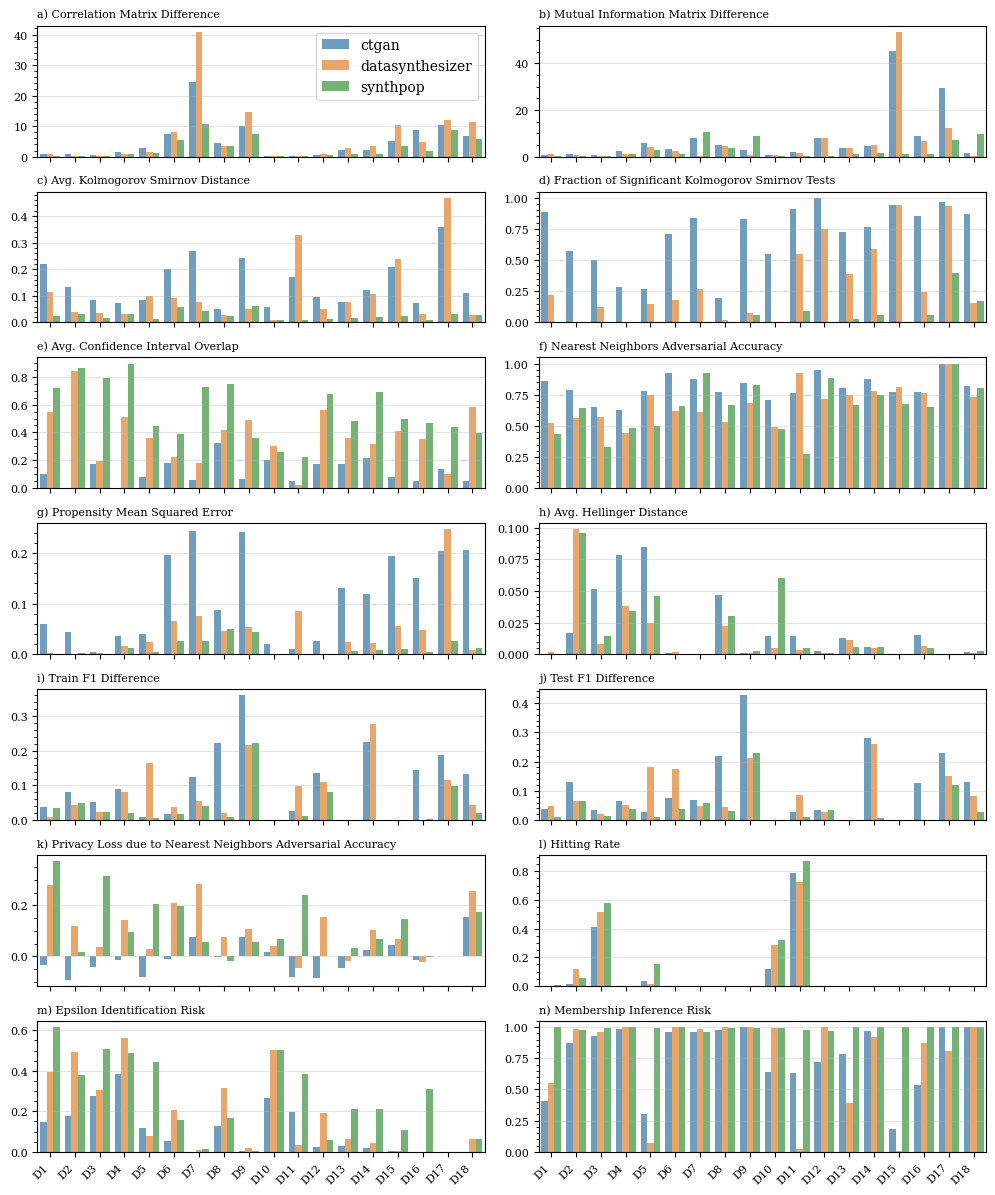

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

rcp = {'font.size': 8, 'font.family': 'serif'}
plt.rcParams.update(**rcp)

global_res = pd.read_csv('evaluation_results.csv')

short_dataset_names = {'diabetes': 'D1','penguins': 'D2','titanic': 'D3','cervical_cancer': 'D5','derm': 'D4','spect': 'D6','diabetic_mellitus': 'D8','mice_protein': 'D9','spectrometer': 'D7','space_titanic': 'D11',
                       'stroke': 'D10','winequality': 'D12','cardiotocography': 'D13','one_hundred_plants': 'D15','steel_faults': 'D14','bankruptcy': 'D17','speed_dating': 'D16','yeast_ml8': 'D18'}
global_res['dataset'] = global_res['dataset'].map(short_dataset_names)
global_res.sort_values(by=['dataset'], inplace=True,key=lambda x: x.str[1:].astype(int))

cols_to_plot = ['corr_mat_diff','mutual_inf_diff','ks_tvd_stat','frac_ks_sigs','avg_cio','nnaa','avg_pMSE','avg_h_dist','cls_F1_diff','cls_F1_diff_hout',
                'priv_loss_nnaa','hit_rate','eps_identif_risk','mia_cls_risk']

plot_titles  = ['a) Correlation Matrix Difference','b) Mutual Information Matrix Difference',
                'c) Avg. Kolmogorov Smirnov Distance','d) Fraction of Significant Kolmogorov Smirnov Tests',
                'e) Avg. Confidence Interval Overlap','f) Nearest Neighbors Adversarial Accuracy',
                'g) Propensity Mean Squared Error','h) Avg. Hellinger Distance',
                'i) Train F1 Difference','j) Test F1 Difference',
                'k) Privacy Loss due to Nearest Neighbors Adversarial Accuracy', 'l) Hitting Rate',
                'm) Epsilon Identification Risk','n) Membership Inference Risk']

### Create subplots
fig, axes = plt.subplots(7, 2, sharex=True, figsize=(10, 12))
for i, ax in enumerate(axes.flatten()):
    
    sns.barplot(global_res, x="dataset", y=cols_to_plot[i]+'_value', hue='model', ax=ax, palette="tab10", alpha=0.7)
    ax.get_legend().remove()

    ax.minorticks_on()
    ax.xaxis.set_tick_params(which='minor', bottom=False)

    ax.yaxis.grid(True, which='major', linestyle='-', linewidth='0.5',alpha=0.5)

    ax.set_title(plot_titles[i], fontsize=8, loc='left')
    ax.set_ylabel('')
    
### Final adjustments
axes[0][0].legend(loc='upper right', fontsize=10)

axes[6][0].set_xlabel('')
axes[6][0].set_xticklabels(axes[6][0].get_xticklabels(), rotation=45, horizontalalignment='right')

axes[6][1].set_xlabel('')
axes[6][1].set_xticklabels(axes[6][1].get_xticklabels(), rotation=45, horizontalalignment='right')

plt.tight_layout()

plt.savefig('histograms_of_model_benchmarks.pdf')
plt.show()

### Time to fit models Vs. the number of attributes - Figure 12
In this part we show relations between the time to fit the models and the number of attributes in the datasets.

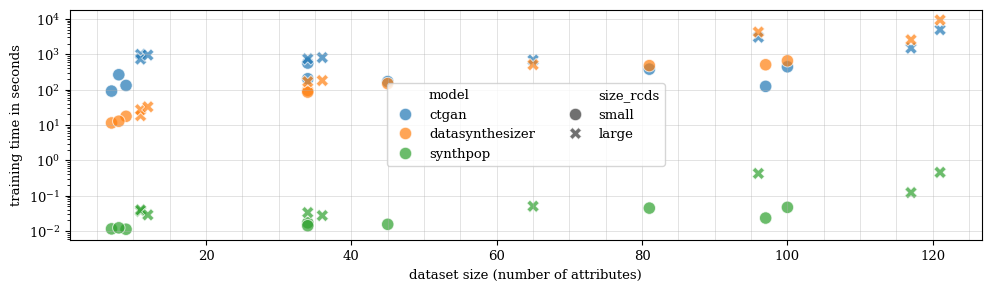

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

rcp = {'font.size': 9.5, 'font.family': 'serif'}
plt.rcParams.update(**rcp)

global_res = pd.read_csv('evaluation_results.csv')

dataset_number_of_attributes = {'diabetes': 9,'penguins': 7,'titanic': 8,'cervical_cancer': 34,'derm': 34,'spect': 45,'diabetic_mellitus': 97,'mice_protein': 81,'spectrometer': 100,'space_titanic': 11,
                                'stroke': 11,'winequality': 12,'cardiotocography': 36,'one_hundred_plants': 65,'steel_faults': 34,'bankruptcy': 96,'speed_dating': 121,'yeast_ml8': 117}
global_res['num_atts'] = global_res['dataset'].map(dataset_number_of_attributes)

### Plotting
fig, ax = plt.subplots(figsize=(10, 3.2))
sns.scatterplot(data=global_res, x='num_atts', y='time', hue='model',style='size_rcds',palette='tab10', alpha=0.7,s=80, ax=ax)

ax.minorticks_on()
ax.xaxis.set_tick_params(which='minor', bottom=False)
ax.grid(True, which='major', linestyle='-', linewidth='0.5', alpha=0.5)
ax.grid(True, axis="x", which='minor', linestyle='-', linewidth='0.5', alpha=0.5)
ax.legend(loc='center', ncol=2)
ax.set_yscale('log')

plt.xlabel('dataset size (number of attributes)')
plt.ylabel('training time in seconds')
plt.tight_layout()
plt.savefig('scatterplot_of_training_times.pdf')
plt.show()



### Privacy metrics compared to the utility scores - Figure 11
In these plots we compare the behaviour of the privacy and utility scores, and show how the privacy metrics behave with increasing utility scores.

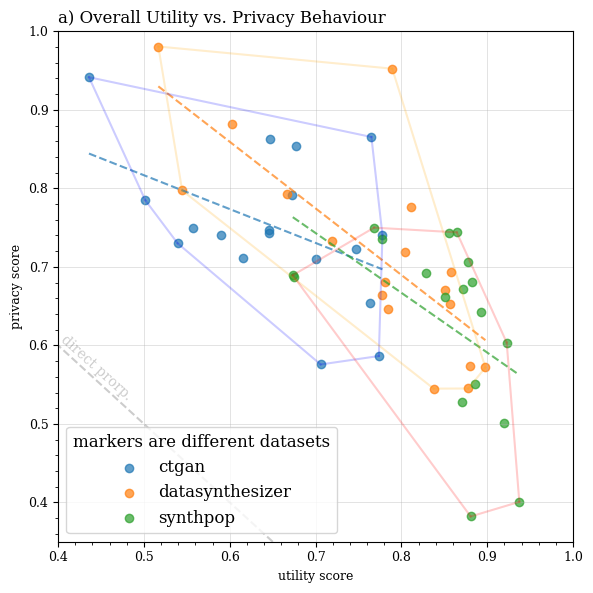

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

rcp = {'font.size': 9, 'font.family': 'serif'}
plt.rcParams.update(**rcp)

def plot_convex_hull(df, ax, model, color, alpha):
    from scipy.spatial import ConvexHull
    points = df[df['model'] == model][['u_rank_','p_rank_']].values
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], color=color, alpha=alpha)

global_res = pd.read_csv('evaluation_results.csv')
global_res["u_rank_"] = global_res["u_rank_"]/10
global_res["p_rank_"] = global_res["p_rank_"]/4

fig, ax = plt.subplots(figsize=(6, 6))

sns.regplot(data=global_res[global_res["model"]=="ctgan"], x="u_rank_", y="p_rank_", ci=None, ax=ax, line_kws={'linestyle':'--', 'linewidth':'1.5', 'alpha':0.7},scatter_kws={'alpha':0.7},label='ctgan')
sns.regplot(data=global_res[global_res["model"]=="datasynthesizer"], x="u_rank_", y="p_rank_",ci=None, ax=ax, line_kws={'linestyle':'--', 'linewidth':'1.5', 'alpha':0.7},scatter_kws={'alpha':0.7},label='datasynthesizer')
sns.regplot(data=global_res[global_res["model"]=="synthpop"], x="u_rank_", y="p_rank_", ci=None, ax=ax, line_kws={'linestyle':'--', 'linewidth':'1.5', 'alpha':0.7},scatter_kws={'alpha':0.7},label='synthpop')

# Add convex hulls
plot_convex_hull(global_res, ax, 'ctgan', 'blue', 0.2)
plot_convex_hull(global_res, ax, 'datasynthesizer', 'orange', 0.2)
plot_convex_hull(global_res, ax, 'synthpop', 'red', 0.2)

# plot a diagonal line to represent the proportional case
plt.plot([1, 0], [0, 1], ls="--", linewidth=1.5, alpha=0.2, color="black")
plt.annotate('direct prorp.', xy=(0.45, 0.55), xytext=(0.4, 0.53),rotation=-42, fontsize=10, alpha=0.2)

# sns.scatterplot(data=global_res, x="u_rank_", y="p_rank_", hue="model", palette="tab10", alpha=0.7,s=80)
plt.axis([0.4, 1, 0.35, 1])
plt.xlabel('utility score')
plt.ylabel('privacy score')
plt.title('a) Overall Utility vs. Privacy Behaviour',loc='left', fontsize=12)
plt.legend(loc='lower left', fontsize=12, title='markers are different datasets', title_fontsize=12)

ax.minorticks_on()
ax.grid(True, which='major', linestyle='-', linewidth='0.5', alpha=0.5)
plt.tight_layout()
plt.savefig('utility_vs_privacy_scores.pdf')
plt.show()

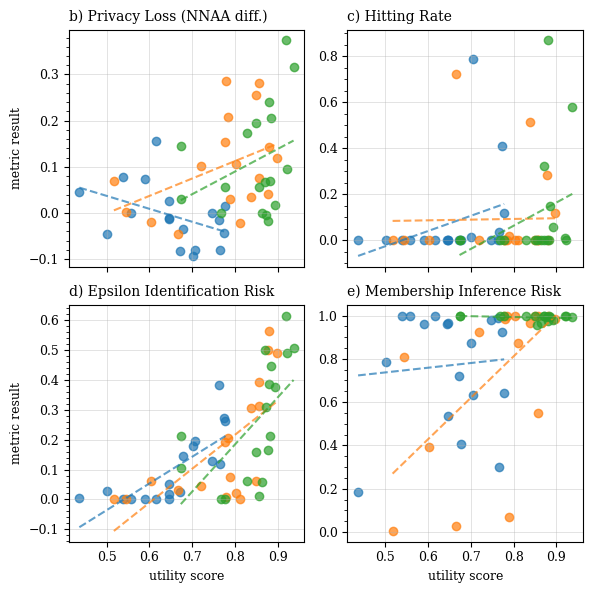

In [37]:
cols_to_plot = ['priv_loss_nnaa','hit_rate','eps_identif_risk','mia_cls_risk']

plot_titles  = ['b) Privacy Loss (NNAA diff.)','c) Hitting Rate','d) Epsilon Identification Risk','e) Membership Inference Risk']

### Create subplots
fig, axes = plt.subplots(2,2, figsize=(6,6),sharex=True)

for i, ax in enumerate(axes.flatten()):
    sns.regplot(data=global_res[global_res["model"]=="ctgan"], x="u_rank_", y=cols_to_plot[i]+"_value", ci=None, ax=ax, line_kws={'linestyle':'--', 'linewidth':'1.5', 'alpha':0.7},scatter_kws={'alpha':0.7},label='ctgan')
    sns.regplot(data=global_res[global_res["model"]=="datasynthesizer"], x="u_rank_", y=cols_to_plot[i]+"_value",ci=None, ax=ax, line_kws={'linestyle':'--', 'linewidth':'1.5', 'alpha':0.7},scatter_kws={'alpha':0.7},label='datasynthesizer')
    sns.regplot(data=global_res[global_res["model"]=="synthpop"], x="u_rank_", y=cols_to_plot[i]+"_value", ci=None, ax=ax, line_kws={'linestyle':'--', 'linewidth':'1.5', 'alpha':0.7},scatter_kws={'alpha':0.7},label='synthpop')
    
    ax.set_title(plot_titles[i], fontsize=10, loc='left')
    ax.set_ylabel('')
    ax.set_xlabel('')

    ax.minorticks_on()
    ax.xaxis.set_tick_params(which='minor', bottom=False)
    ax.grid(True, which='major', linestyle='-', linewidth='0.5', alpha=0.5)
    # ax.grid(True, axis="x", which='minor', linestyle='-', linewidth='0.5', alpha=0.5)

# axes[0].legend()

axes[0,0].set_ylabel('metric result')
axes[1,0].set_ylabel('metric result')

axes[1,0].set_xlabel('utility score')
axes[1,1].set_xlabel('utility score')
plt.tight_layout()

plt.savefig('plots_of_privacy_metrics.pdf')
plt.show()

### Matrix of Metrics Correlation - Figure 13
In this part we show the correlation between the metrics used in the evaluation. 

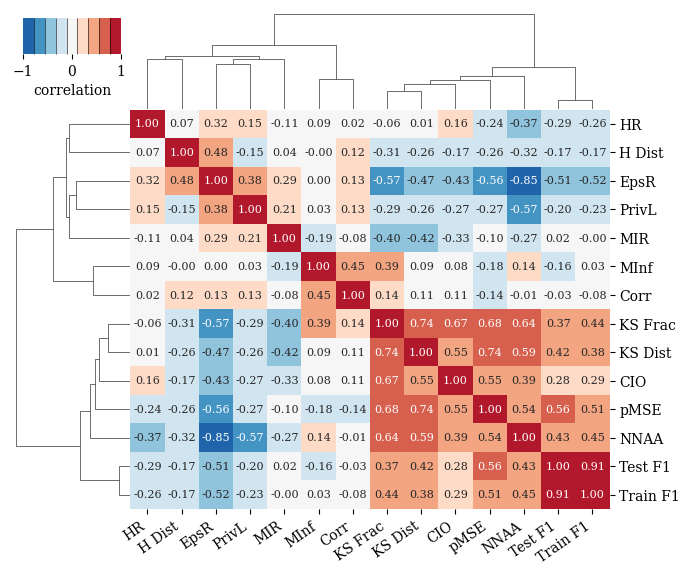

In [45]:
import pandas as pd
import seaborn as sns

rcp = {'font.size': 10, 'font.family': 'serif'}
plt.rcParams.update(**rcp)

global_res = pd.read_csv('rank_results.csv')

rename_cols_dict = {'corr_mat_diff': 'Corr',
                    'mutual_inf_diff': 'MInf',
                    'ks_tvd_stat': 'KS Dist',
                    'frac_ks_sigs': 'KS Frac',
                    'avg_cio': 'CIO',
                    'nnaa': 'NNAA',
                    'avg_pMSE': 'pMSE',
                    'avg_h_dist': 'H Dist',
                    'cls_F1_diff': 'Train F1',
                    'cls_F1_diff_hout': 'Test F1',
                    'priv_loss_nnaa': 'PrivL',
                    'hit_rate': 'HR',
                    'eps_identif_risk': 'EpsR',
                    'mia_cls_risk': 'MIR'}
global_res.rename(columns=rename_cols_dict, inplace=True)

cols_to_plot = ['Corr','MInf','KS Dist','KS Frac','CIO','NNAA','pMSE','H Dist','Train F1','Test F1','PrivL','HR','EpsR','MIR']

def _shortened_labels(ax_get_ticks):
    max_label_length = 10
    labels = [label.get_text()[:max_label_length] + '...' if len(label.get_text()) > max_label_length else label.get_text() for label in ax_get_ticks]
    return labels

correlations = global_res[cols_to_plot].corr()

colors = sns.color_palette("RdBu_r", 9)
result = sns.clustermap(correlations, dendrogram_ratio=0.2, annot=True, fmt=".2f",annot_kws={"fontsize":8}, cmap=colors, cbar_kws={"label" : "correlation","orientation":'horizontal' ,"drawedges": True}, vmin=-1, vmax=1, figsize=(7,6))

result.ax_heatmap.invert_xaxis()
result.ax_heatmap.invert_yaxis()
result.ax_col_dendrogram.invert_xaxis()
result.ax_row_dendrogram.invert_yaxis()

# result.cax.set_frame_on(True)
result.cax.set_position([.04, .90, .14, .06])

labels = _shortened_labels(result.ax_heatmap.get_xticklabels())
result.ax_heatmap.set_xticks(result.ax_heatmap.get_xticks(), labels, rotation=35, ha='right')
result.ax_heatmap.set_yticks(result.ax_heatmap.get_yticks(), labels)

# plt.tight_layout()
plt.savefig('metric_corr_clust_heatmap.pdf')
plt.show()